# Regression analysis for box office

## Data preprocessing for box office

In [1]:
#import files
from google.colab import files
uploaded = files.upload()
import pandas as pd
import io

Saving boxofficemojo_releases.csv to boxofficemojo_releases.csv


In [2]:
!pip install impyute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import sys
from impyute.imputation.cs import fast_knn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn import pipeline
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
import xgboost as xg
import matplotlib.pyplot as plt

In [68]:
df = pd.read_csv(io.BytesIO(uploaded['boxofficemojo_releases.csv']))

In [69]:
#only maintain interested variables
df = df.drop(columns=['identifier', 'old_bomojo_id','title','imdb_title_identifier','imdb_title_bomojo_url','domestic_opening','release_date','synopsis','running_time','hsx_symbol','bomojo_type','url','updated_at'])

In [70]:
#leave only numbers in widest_release
df['widest_release'] = df['widest_release'].str.replace('[,,theaters]','')
df['widest_release'] = pd.to_numeric(df['widest_release'], errors='coerce').fillna(0).astype(int)

<ipython-input-70-6c8a3fd517ca>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['widest_release'] = df['widest_release'].str.replace('[,,theaters]','')


In [71]:
#replace the 0 value with NaN
df.replace(0,np.nan, inplace=True)

In [72]:
#encode the non-numeric to numeric
categorical_cols = ['distributor_name', 'genres', 'mpaa_rating']
le = LabelEncoder()
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))

In [73]:
#apply KNN imputation to replace the NaN
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
# start the KNN training
df=fast_knn(df.values, k=30)

In [74]:
df=pd.DataFrame(df,columns=['budget','distributor_name','domestic_gross','international_gross','worldwide_gross','widest_release','genres','mpaa_rating'])

In [75]:
#normalize the data
cols_to_scale=['budget','distributor_name','domestic_gross','international_gross','worldwide_gross','widest_release','genres','mpaa_rating']
scaler=MinMaxScaler()
df[cols_to_scale]=scaler.fit_transform(df[cols_to_scale])

In [76]:
cols_to_train=['budget','distributor_name','widest_release','genres','mpaa_rating']

## Model for domestic gross

In [176]:
X_train,X_valid,y_train_dg,y_valid_dg=train_test_split(df[cols_to_train],df['domestic_gross'],random_state=42,test_size=0.3)

In [177]:
#set the models and parameters that are going to be tuned
models = [Ridge(), Lasso()]
alphas=np.logspace(-2,2,200)

In [178]:
#iterate through the models and parameters to find the best model settings
results_list_dg = []
for model in models:
  for a in alphas:
    pipe=pipeline.Pipeline([('regre', model)])
    pipe.set_params(regre__alpha=a).fit(X_train, y_train_dg)
    mse = mean_squared_error(y_true=y_valid_dg, y_pred=pipe.predict(X_valid))
    results_dict = {
        'model': str(model),
        'alpha': a,
        'mse': mse
    }
    results_list_dg.append(results_dict)

In [179]:
#find the best model with parameters
results_df_dg = pd.DataFrame(results_list_dg)
results_df_dg[results_df_dg["mse"]==np.min(results_df_dg["mse"])]

,model,alpha,mse
0,Ridge(alpha=0.01),0.01,0.000992


In [181]:
model_dg=Ridge(alpha=0.01)
model_dg.fit(X_train,y_train_dg)

Ridge(alpha=0.01)

In [182]:
#Find out the coefficient of each feature
coef_magnitudes_dg = np.abs(model_dg.coef_)
coef_magnitudes_dg = coef_magnitudes_dg.reshape(1,-1)
Importance_dg=pd.DataFrame(data=coef_magnitudes_dg,columns=cols_to_train)

In [183]:
# the largest coefficient has the largest impact on the response
Importance_dg

,budget,distributor_name,widest_release,genres,mpaa_rating
0,0.289852,0.001598,0.130241,0.004163,0.003479


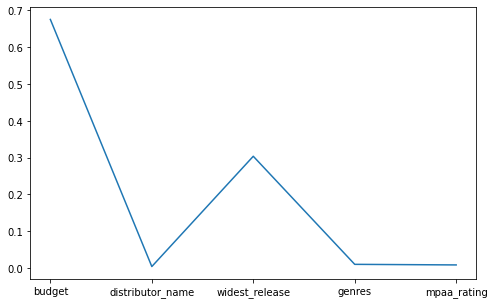

In [184]:
# what features are the most important?
plt.figure(figsize=(8,5))
plt.plot(cols_to_train, np.divide(np.abs(model_dg.coef_),np.sum(np.abs(model_dg.coef_))))

## Model for international gross

In [185]:
X_train,X_valid,y_train_ig,y_valid_ig=train_test_split(df[cols_to_train],df['international_gross'],random_state=42,test_size=0.3)

In [186]:
results_list_ig = []
for model in models:
  for a in alphas:
    pipe=pipeline.Pipeline([('regre', model)])
    pipe.set_params(regre__alpha=a).fit(X_train, y_train_ig)
    mse = mean_squared_error(y_true=y_valid_ig, y_pred=pipe.predict(X_valid))
    results_dict = {
        'model': str(model),
        'alpha': a,
        'mse': mse
    }
    results_list_ig.append(results_dict)

In [187]:
#find the best model with parameters
results_df_ig = pd.DataFrame(results_list_ig)
results_df_ig[results_df_ig["mse"]==np.min(results_df_ig["mse"])]

,model,alpha,mse
0,Ridge(alpha=0.01),0.01,0.000659


In [188]:
model_ig=Ridge(alpha=0.01)
model_ig.fit(X_train,y_train_ig)

Ridge(alpha=0.01)

In [189]:
#Find out the coefficient of each feature
coef_magnitudes_ig = np.abs(model_ig.coef_)
coef_magnitudes_ig = coef_magnitudes_ig.reshape(1,-1)
Importance_ig=pd.DataFrame(data=coef_magnitudes_ig,columns=cols_to_train)

In [190]:
# the largest coefficient has the largest impact on the response
Importance_ig

,budget,distributor_name,widest_release,genres,mpaa_rating
0,0.323197,0.000189,0.048113,0.0003,0.002933


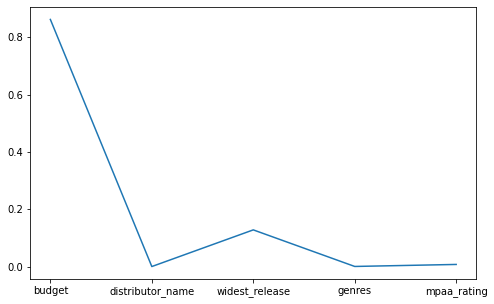

In [191]:
# what features are the most important?
plt.figure(figsize=(8,5))
plt.plot(cols_to_train, np.divide(np.abs(model_ig.coef_),np.sum(np.abs(model_ig.coef_))))

## Model for worldwide gross

In [192]:
X_train,X_valid,y_train_wg,y_valid_wg=train_test_split(df[cols_to_train],df['worldwide_gross'],random_state=42,test_size=0.3)

In [193]:
results_list_wg = []
for model in models:
  for a in alphas:
    pipe=pipeline.Pipeline([('regre', model)])
    pipe.set_params(regre__alpha=a).fit(X_train, y_train_wg)
    mse = mean_squared_error(y_true=y_valid_wg, y_pred=pipe.predict(X_valid))
    results_dict = {
        'model': str(model),
        'alpha': a,
        'mse': mse
    }
    results_list_wg.append(results_dict)

In [194]:
#find the best model with parameters
results_df_wg = pd.DataFrame(results_list_wg)
results_df_wg[results_df_wg["mse"]==np.min(results_df_wg["mse"])]

,model,alpha,mse
0,Ridge(alpha=0.01),0.01,0.00072


In [195]:
model_wg=Ridge(alpha=0.01)
model_wg.fit(X_train,y_train_wg)

Ridge(alpha=0.01)

In [196]:
#Find out the coefficient of each feature
coef_magnitudes_wg = np.abs(model_wg.coef_)
coef_magnitudes_wg = coef_magnitudes_wg.reshape(1,-1)
Importance_wg=pd.DataFrame(data=coef_magnitudes_wg,columns=cols_to_train)

In [197]:
# the largest coefficient has the largest impact on the response
Importance_wg

,budget,distributor_name,widest_release,genres,mpaa_rating
0,0.324911,0.000534,0.086223,0.000078,0.002554


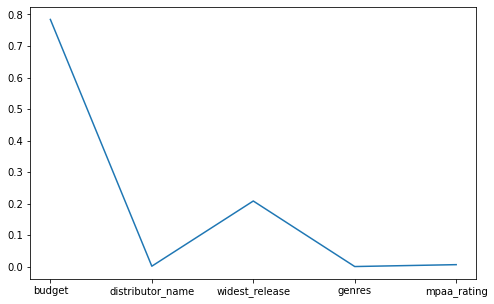

In [198]:
# what features are the most important?
plt.figure(figsize=(8,5))
plt.plot(cols_to_train, np.divide(np.abs(model_wg.coef_),np.sum(np.abs(model_wg.coef_))))

# Regression analysis for avg stock price and stock volatility

## Data preprocessing for avg stock price and stock volatility

In [130]:
uploaded = files.upload()

Saving stock_avgprice_and_volatility.csv to stock_avgprice_and_volatility.csv


In [131]:
df1 = pd.read_csv(io.BytesIO(uploaded['stock_avgprice_and_volatility.csv']))

In [134]:
uploaded = files.upload()

Saving hsx_movie_master.csv to hsx_movie_master.csv


In [135]:
df2 = pd.read_csv(io.BytesIO(uploaded['hsx_movie_master.csv']))

In [136]:
#join two dataframe by identifier
df_new = []
for i in range(len(df1['identifier'])):
  identifier = df1['identifier'][i]
  row = df2[df2['identifier']==identifier]
  row = pd.concat([df1.iloc[i], row.squeeze().drop('identifier')])
  row = row.drop('Unnamed: 0')
  df_new.append(row)
df_new = pd.DataFrame(df_new)

In [137]:
#only maintain interested variables
df_new = df_new.drop(columns=['identifier','title','synopsis','status','phase','url','ipo_date','release_date','delist_date','theaters','release_pattern','domestic_gross','updated_at'])

In [140]:
df_new['genres'] = df_new['genres'].str.replace('\[', '',regex=True).str.replace('\]','',regex=True).str.replace('\'','',regex=True)

In [149]:
#encode the non-numeric to numeric
col_to_encode = ['genres', 'mpaa_rating', 'distributor']
le = LabelEncoder()
df_new[col_to_encode] = df_new[col_to_encode].apply(lambda col: le.fit_transform(col))

## Regression for average_price

In [200]:
col_to_train=['genres','mpaa_rating','distributor']
X=df_new[col_to_train]
y_ap=df_new['average_price']
X_train,X_valid,y_train_ap,y_valid_ap=train_test_split(X,y_ap,test_size=0.3,random_state=42)

In [201]:
results_list_ap=[]
for model in models:
  for a in alphas:
    pipe=pipeline.Pipeline([('regre', model)])
    pipe.set_params(regre__alpha=a).fit(X_train, y_train_ap)
    mse = mean_squared_error(y_true=y_valid_ap, y_pred=pipe.predict(X_valid))
    results_dict = {
        'model': str(model),
        'alpha': a,
        'mse': mse
    }
    results_list_ap.append(results_dict)

In [202]:
#find the best model with parameters
results_df_ap = pd.DataFrame(results_list_ap)
results_df_ap[results_df_ap["mse"]==np.min(results_df_ap["mse"])]

,model,alpha,mse
302,Lasso(alpha=1.1226677735108135),1.122668,2075.3364


In [203]:
model_ap=Lasso(alpha=1.12)
model_ap.fit(X_train,y_train_ap)

Lasso(alpha=1.12)

In [205]:
#Find out the coefficient of each feature
coef_magnitudes_ap = np.abs(model_ap.coef_)
coef_magnitudes_ap = coef_magnitudes_ap.reshape(1,-1)
Importance_ap=pd.DataFrame(data=coef_magnitudes_ap,columns=col_to_train)

In [206]:
# the largest coefficient has the largest impact on the response
Importance_ap

,genres,mpaa_rating,distributor
0,1.151489,0.0,0.05652


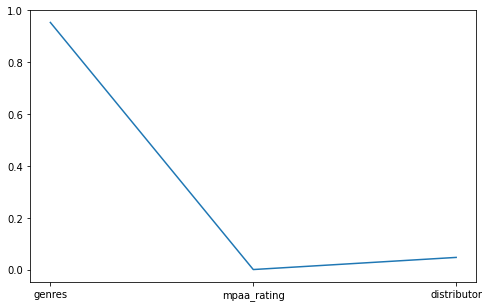

In [207]:
# what features are the most important?
plt.figure(figsize=(8,5))
plt.plot(col_to_train, np.divide(np.abs(model_ap.coef_),np.sum(np.abs(model_ap.coef_))))

## Regression for volatility


In [208]:
y_v=df_new['volatility']
X_train,X_valid,y_train_v,y_valid_v=train_test_split(X,y_v,test_size=0.3,random_state=42)

In [213]:
results_list_v=[]
for model in models:
  for a in alphas:
    pipe=pipeline.Pipeline([('regre', model)])
    pipe.set_params(regre__alpha=a).fit(X_train, y_train_v)
    mse = mean_squared_error(y_true=y_valid_v, y_pred=pipe.predict(X_valid))
    results_dict = {
        'model': str(model),
        'alpha': a,
        'mse': mse
    }
    results_list_v.append(results_dict)

In [214]:
#find the best model with parameters
results_df_v = pd.DataFrame(results_list_v)
results_df_v[results_df_v["mse"]==np.min(results_df_v["mse"])]

,model,alpha,mse
224,Lasso(alpha=0.030367711180354574),0.030368,0.05524


In [215]:
model_v=Lasso(alpha=0.03)
model_v.fit(X_train,y_train_v)

Lasso(alpha=0.03)

In [216]:
#Find out the coefficient of each feature
coef_magnitudes_v = np.abs(model_v.coef_)
coef_magnitudes_v = coef_magnitudes_v.reshape(1,-1)
Importance_v=pd.DataFrame(data=coef_magnitudes_v,columns=col_to_train)

In [219]:
# the largest coefficient has the largest impact on the response
Importance_v

,genres,mpaa_rating,distributor
0,0.000564,0.0,0.001057


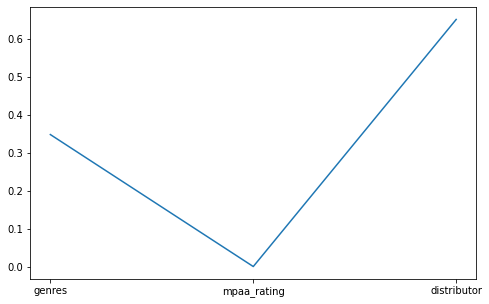

In [220]:
# what features are the most important?
plt.figure(figsize=(8,5))
plt.plot(col_to_train, np.divide(np.abs(model_v.coef_),np.sum(np.abs(model_v.coef_))))